In [1]:
%load_ext Cython

In [2]:
%%cython
from cython cimport boundscheck, wraparound
import numpy as np

ctypedef double complex dcx

cdef inline double norm2(dcx z) nogil:
    return z.real * z.real + z.imag * z.imag

cdef int escape(dcx z, dcx c, double z_max, int n_max) nogil:
    cdef:
        int i = 0
        double z_max2 = z_max * z_max
    while norm2(z) < z_max2 and i < n_max:
        z = z * z + c
        i += 1
    return i

@boundscheck(False)
@wraparound(False)
def calc_julia(int resolution, dcx c, double bound=1.5,
               double z_max=4.0, int n_max=1000):
    cdef:
        double step = 2.0 * bound / resolution
        int i, j
        dcx z
        double real, imag
        int[:, ::1] counts
    counts = np.zeros((resolution+1, resolution+1), dtype=np.int32)
    
    for i in range(resolution+1):
        real = -bound + i * step
        for j in range(resolution+1):
            imag = -bound + j * step
            z = real + imag * 1j
            counts[i, j] = escape(z, c, z_max, n_max)
    
    return np.asarray(counts)

In [3]:
%timeit -n3 -r3 calc_julia(1200, (0.322 + 0.05j))

3 loops, best of 3: 1.21 s per loop


<IPython.core.display.Javascript object>


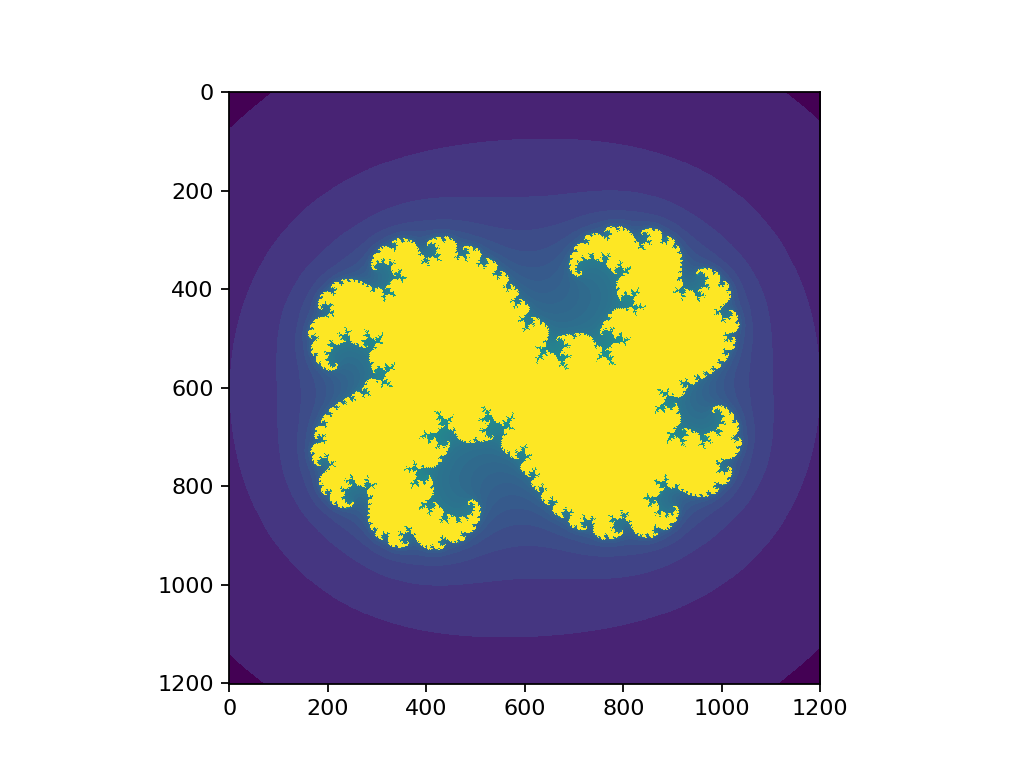

In [4]:
%matplotlib notebook
import matplotlib.pyplot as plt
import numpy as np

jl = calc_julia(1200, (0.322 + 0.05j))
plt.imshow(np.log(jl))
plt.show()

In [24]:
%%cython
# distutils: extra_compile_args = -fopenmp
# # distutils: extra_compile_args = -O3
# distutils: extra_link_args = -fopenmp
from cython cimport boundscheck, wraparound
import numpy as np
from cython.parallel cimport prange

ctypedef double complex dcx

cdef inline double norm2(dcx z) nogil:
    return z.real * z.real + z.imag * z.imag

cdef int escape(dcx z, dcx c, double z_max, int n_max) nogil:
    cdef:
        int i = 0
        double z_max2 = z_max * z_max
    while norm2(z) < z_max2 and i < n_max:
        z = z * z + c
        i += 1
    return i

@boundscheck(False)
@wraparound(False)
def calc_julia1(int resolution, dcx c, double bound=1.5,
               double z_max=4.0, int n_max=1000):
    cdef:
        double step = 2.0 * bound / resolution
        int i, j
        dcx z
        double real, imag
        int[:, ::1] counts
    counts = np.zeros((resolution+1, resolution+1), dtype=np.int32)
    
    with nogil:
        for i in prange(resolution+1):
            real = -bound + i * step
            for j in range(resolution+1):
                imag = -bound + j * step
                z = real + imag * 1j
                counts[i, j] = escape(z, c, z_max, n_max)
    
    return np.asarray(counts)

In [25]:
%timeit -n3 -r3 calc_julia1(1200, (0.322 + 0.05j))

3 loops, best of 3: 612 ms per loop


In [12]:
%%cython
# distutils: extra_compile_args = -fopenmp
# distutils: extra_link_args = -fopenmp
from cython cimport boundscheck, wraparound
import numpy as np
from cython.parallel cimport prange

ctypedef double complex dcx

cdef inline double norm2(dcx z) nogil:
    return z.real * z.real + z.imag * z.imag

cdef int escape(dcx z, dcx c, double z_max, int n_max) nogil:
    cdef:
        int i = 0
        double z_max2 = z_max * z_max
    while norm2(z) < z_max2 and i < n_max:
        z = z * z + c
        i += 1
    return i

@boundscheck(False)
@wraparound(False)
def calc_julia2(int resolution, dcx c, double bound=1.5,
               double z_max=4.0, int n_max=1000):
    cdef:
        double step = 2.0 * bound / resolution
        int i, j
        dcx z
        double real, imag
        int[:, ::1] counts
    counts = np.zeros((resolution+1, resolution+1), dtype=np.int32)
    
    for i in prange(resolution+1, nogil=True, schedule='dynamic', chunksize=1):
        real = -bound + i * step
        for j in range(resolution+1):
            imag = -bound + j * step
            z = real + imag * 1j
            counts[i, j] = escape(z, c, z_max, n_max)
    
    return np.asarray(counts)

In [13]:
%timeit -n3 -r3 calc_julia2(1200, (0.322 + 0.05j))

3 loops, best of 3: 403 ms per loop
